In [4]:
import numpy as np
import xgboost as xgb
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc 
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False 

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score

import xgboost as xgb
from xgboost import plot_importance
import optuna

In [6]:
# load data
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
display(train,test)

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,NaN,0
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,NaN,0.0,NaN,70.0,0.0,0.0,NaN,NaN,NaN,1
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,NaN,2.0,...,7.0,1.0,4.0,7.0,0.0,1.0,NaN,NaN,0.0,0
3,BC_01_0004,./train_imgs/BC_01_0004.png,-,54,2016-03-08,1,2,1,0.0,3.0,...,NaN,0.0,NaN,1.0,1.0,3.0,NaN,NaN,NaN,0
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,...,8.0,0.0,NaN,8.0,1.0,2.0,1.0,5.44,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,BC_01_3464,./train_imgs/BC_01_3464.png,-,65,2006-12-22,1,2,1,25.0,1.0,...,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1
996,BC_01_3482,./train_imgs/BC_01_3482.png,-,48,2006-11-17,1,1,1,7.0,1.0,...,NaN,1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0
997,BC_01_3485,./train_imgs/BC_01_3485.png,-,64,2006-11-10,1,2,1,15.0,1.0,...,NaN,1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1
998,BC_01_3502,./train_imgs/BC_01_3502.png,-,50,2006-09-22,1,1,1,7.0,1.0,...,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0


,ID,img_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,HG,...,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation
0,BC_01_0011,./test_imgs/BC_01_0011.png,55,2015-11-17,2,2,1,23.0,2.0,2.0,...,1.0,8.0,0.0,2.0,5.00,0.0,1.0,NaN,NaN,NaN
1,BC_01_0220,./test_imgs/BC_01_0220.png,43,2020-06-09,4,2,1,13.0,3.0,2.0,...,1.0,4.0,1.0,8.0,8.67,0.0,0.0,NaN,NaN,NaN
2,BC_01_0233,./test_imgs/BC_01_0233.png,76,2020-05-14,1,1,1,NaN,NaN,NaN,...,1.0,6.0,1.0,6.0,NaN,NaN,2.0,NaN,NaN,NaN
3,BC_01_0258,./test_imgs/BC_01_0258.png,58,2020-05-20,1,2,1,1.3,2.0,2.0,...,1.0,7.0,0.0,NaN,21.17,1.0,3.0,NaN,NaN,0.0
4,BC_01_0260,./test_imgs/BC_01_0260.png,56,2020-05-20,1,2,2,15.0,3.0,3.0,...,1.0,8.0,1.0,3.0,20.57,1.0,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,BC_01_3328,./test_imgs/BC_01_3328.png,61,2009-10-30,1,1,1,18.0,2.0,2.0,...,1.0,5.0,1.0,3.0,NaN,0.0,0.0,NaN,NaN,NaN
246,BC_01_3404,./test_imgs/BC_01_3404.png,42,2009-05-19,1,2,1,20.0,1.0,2.0,...,1.0,5.0,1.0,5.0,NaN,0.0,1.0,NaN,NaN,NaN
247,BC_01_3418,./test_imgs/BC_01_3418.png,37,2009-04-24,1,1,1,17.0,1.0,1.0,...,1.0,5.0,1.0,5.0,NaN,0.0,0.0,NaN,NaN,NaN
248,BC_01_3438,./test_imgs/BC_01_3438.png,37,2009-02-06,1,1,1,7.0,1.0,1.0,...,1.0,5.0,1.0,5.0,NaN,0.0,0.0,NaN,NaN,NaN


In [7]:
train['암의 장경'] = train['암의 장경'].fillna(train['암의 장경'].mean())
train = train.fillna(0)

test['암의 장경'] = test['암의 장경'].fillna(test['암의 장경'].mean())
test = test.fillna(0)

In [8]:
train.drop(columns=['ID', 'img_path', 'mask_path', '수술연월일'], inplace=True )
test.drop(columns=['ID', 'img_path', '수술연월일'], inplace=True )

In [9]:
# 타겟과 분리
X = train.iloc[:,:23]
Y = train.iloc[:,23:]
Y

,N_category
0,0
1,1
2,0
3,0
4,0
...,...
995,1
996,0
997,1
998,0


In [10]:
seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# train

In [11]:
def RF_objective(trial: optuna.trial.Trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric':'auc',
        'booster':'gbtree',
        'n_estimators': trial.suggest_int("n_estimators", 100, 1000, step=10),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        
        # 'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'gpu_id': 0, # GPU 사용시
        "tree_method": 'exact', 'gpu_id': -1,  # CPU 사용시
        
        "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1),
        # 'scale_pos_weight': scale_pos_weight
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 5, 20, step=5)
        
        # "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
        # 'num_parallel_tree': trial.suggest_int("num_parallel_tree", 1, 500) 추가하면 느려짐.
    }

    model = xgb.XGBClassifier(**params, random_state = 42, use_label_encoder = False, n_jobs=-1)
    
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
    f1_mean = score.mean()

    return f1_mean

In [12]:
RF_study = optuna.create_study()
RF_study.optimize(RF_objective, n_trials=100)

[I 2022-11-22 15:27:42,222] A new study created in memory with name: no-name-a2593cd6-dd9a-4ea9-b235-1d1d53075464
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:19: FutureWarning: suggest_loguniform has been deprecated 

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:28:17,536] Trial 2 finished with value: 0.7637616043451727 and parameters: {'n_estimators': 360, 'max_depth': 5, 'gamma': 0.11881108100100074, 'min_child_weight': 4, 'subsample': 0.7, 'colsample_bytree': 0.5950095454976246, 'colsample_bylevel': 0.6134899011752214, 'colsample_bynode': 0.8479772165164515, 'reg_lambda': 0.02763425915915359, 'reg_alpha': 0.061120730285235673}. Best is trial 2 with value: 0.7637616043451727.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :fun

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:28:28,909] Trial 5 finished with value: 0.783279990094142 and parameters: {'n_estimators': 110, 'max_depth': 8, 'gamma': 0.15938250506711152, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.7917390009316201, 'colsample_bylevel': 0.5304041103627392, 'colsample_bynode': 0.6337427499438457, 'reg_lambda': 0.014899451035215132, 'reg_alpha': 0.011159364876228968}. Best is trial 4 with value: 0.7618691650083675.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :fun

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:28:39,696] Trial 8 finished with value: 0.8037276316879318 and parameters: {'n_estimators': 320, 'max_depth': 10, 'gamma': 0.29743269997420724, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 0.6506734096552447, 'colsample_bylevel': 0.6412164549239152, 'colsample_bynode': 0.9239449734657533, 'reg_lambda': 0.014770438399167031, 'reg_alpha': 0.12489165906503527}. Best is trial 6 with value: 0.7596667135753823.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :fu

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:28:54,221] Trial 11 finished with value: 0.7518629952085568 and parameters: {'n_estimators': 990, 'max_depth': 7, 'gamma': 0.3860005323056574, 'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.8145993806416079, 'colsample_bylevel': 0.5211659989776597, 'colsample_bynode': 0.7824472589566649, 'reg_lambda': 0.4468916129012949, 'reg_alpha': 0.038722915026358495}. Best is trial 11 with value: 0.7518629952085568.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :fun

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:29:07,912] Trial 14 finished with value: 0.7637149014019595 and parameters: {'n_estimators': 820, 'max_depth': 9, 'gamma': 0.22503347653121805, 'min_child_weight': 4, 'subsample': 0.95, 'colsample_bytree': 0.9138320125748839, 'colsample_bylevel': 0.5803709231222494, 'colsample_bynode': 0.828607276288653, 'reg_lambda': 0.3375817939457709, 'reg_alpha': 0.09430772888612166}. Best is trial 11 with value: 0.7518629952085568.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :fun

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:29:22,921] Trial 17 finished with value: 0.7728581580875107 and parameters: {'n_estimators': 720, 'max_depth': 6, 'gamma': 0.885307138909801, 'min_child_weight': 4, 'subsample': 0.65, 'colsample_bytree': 0.7560112114388203, 'colsample_bylevel': 0.5035638687064099, 'colsample_bynode': 0.5360593502024551, 'reg_lambda': 0.20708412936521564, 'reg_alpha': 0.8896515892592589}. Best is trial 11 with value: 0.7518629952085568.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:29:36,812] Trial 20 finished with value: 0.7713232455059901 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'gamma': 0.24072611846996314, 'min_child_weight': 3, 'subsample': 0.75, 'colsample_bytree': 0.8340610406108685, 'colsample_bylevel': 0.5679955024391427, 'colsample_bynode': 0.7617168064696973, 'reg_lambda': 0.20377163591393865, 'reg_alpha': 0.0178803335867028}. Best is trial 11 with value: 0.7518629952085568.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :f

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:29:49,956] Trial 23 finished with value: 0.7611046649986293 and parameters: {'n_estimators': 760, 'max_depth': 7, 'gamma': 0.30111181889502564, 'min_child_weight': 3, 'subsample': 0.7, 'colsample_bytree': 0.8951038453454006, 'colsample_bylevel': 0.600490264155543, 'colsample_bynode': 0.5787921085353673, 'reg_lambda': 0.24692453290577784, 'reg_alpha': 0.04859155018794516}. Best is trial 11 with value: 0.7518629952085568.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :fun

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:30:02,830] Trial 26 finished with value: 0.762577377064113 and parameters: {'n_estimators': 430, 'max_depth': 4, 'gamma': 0.6262550602071806, 'min_child_weight': 4, 'subsample': 0.6, 'colsample_bytree': 0.7421557004062068, 'colsample_bylevel': 0.827829146375959, 'colsample_bynode': 0.7517029816405185, 'reg_lambda': 0.44527936324641937, 'reg_alpha': 0.07597357435687188}. Best is trial 11 with value: 0.7518629952085568.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:30:10,602] Trial 29 finished with value: 0.7650759334158597 and parameters: {'n_estimators': 200, 'max_depth': 5, 'gamma': 0.6784696547088246, 'min_child_weight': 2, 'subsample': 0.6, 'colsample_bytree': 0.5500815996823908, 'colsample_bylevel': 0.6055648317537853, 'colsample_bynode': 0.7278258770456605, 'reg_lambda': 0.3814916747262957, 'reg_alpha': 0.010011067797142318}. Best is trial 11 with value: 0.7518629952085568.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :fun

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:30:24,242] Trial 32 finished with value: 0.7731639650580824 and parameters: {'n_estimators': 950, 'max_depth': 6, 'gamma': 0.502844921967522, 'min_child_weight': 3, 'subsample': 0.75, 'colsample_bytree': 0.8680381016486147, 'colsample_bylevel': 0.5390271975275531, 'colsample_bynode': 0.6559072313768858, 'reg_lambda': 0.16585761115266942, 'reg_alpha': 0.04726057766102671}. Best is trial 11 with value: 0.7518629952085568.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :fun

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:30:37,079] Trial 35 finished with value: 0.7746618752378156 and parameters: {'n_estimators': 960, 'max_depth': 5, 'gamma': 0.4123764217516566, 'min_child_weight': 2, 'subsample': 0.65, 'colsample_bytree': 0.6800108332080453, 'colsample_bylevel': 0.6481776188798993, 'colsample_bynode': 0.7696723528547226, 'reg_lambda': 0.19169023283582123, 'reg_alpha': 0.05859750053361647}. Best is trial 11 with value: 0.7518629952085568.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :fu

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:30:47,548] Trial 38 finished with value: 0.7533021258660204 and parameters: {'n_estimators': 730, 'max_depth': 10, 'gamma': 0.10034420300931986, 'min_child_weight': 5, 'subsample': 0.6, 'colsample_bytree': 0.680306949844943, 'colsample_bylevel': 0.538051554283559, 'colsample_bynode': 0.8335495201521493, 'reg_lambda': 0.021010222184073647, 'reg_alpha': 0.030621505828455263}. Best is trial 36 with value: 0.7476578050027597.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :f

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:30:58,880] Trial 41 finished with value: 0.7516959129647635 and parameters: {'n_estimators': 680, 'max_depth': 10, 'gamma': 0.10336357967309578, 'min_child_weight': 5, 'subsample': 0.6, 'colsample_bytree': 0.7351069642526166, 'colsample_bylevel': 0.5373871260613867, 'colsample_bynode': 0.9010211019154427, 'reg_lambda': 0.02104310040898306, 'reg_alpha': 0.014621925865414309}. Best is trial 39 with value: 0.7424456367234946.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:31:11,684] Trial 44 finished with value: 0.766046776253327 and parameters: {'n_estimators': 610, 'max_depth': 10, 'gamma': 0.1105020947583989, 'min_child_weight': 5, 'subsample': 0.6, 'colsample_bytree': 0.7285808210726702, 'colsample_bylevel': 0.5559507341900433, 'colsample_bynode': 0.889598056656868, 'reg_lambda': 0.04034505680180031, 'reg_alpha': 0.014059774644806797}. Best is trial 39 with value: 0.7424456367234946.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :fun

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:31:24,433] Trial 47 finished with value: 0.7544865571351477 and parameters: {'n_estimators': 650, 'max_depth': 9, 'gamma': 0.15125714084667277, 'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.7717078894291285, 'colsample_bylevel': 0.9756416087940323, 'colsample_bynode': 0.9552643791249361, 'reg_lambda': 0.03157011988576978, 'reg_alpha': 0.019320891496509614}. Best is trial 39 with value: 0.7424456367234946.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :f

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:31:39,026] Trial 50 finished with value: 0.741330685432285 and parameters: {'n_estimators': 700, 'max_depth': 10, 'gamma': 0.17243762093581938, 'min_child_weight': 5, 'subsample': 0.75, 'colsample_bytree': 0.7816592392403022, 'colsample_bylevel': 0.6301614764272896, 'colsample_bynode': 0.859647192403844, 'reg_lambda': 0.015492967386708769, 'reg_alpha': 0.020241239004041914}. Best is trial 50 with value: 0.741330685432285.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :f

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:31:52,985] Trial 53 finished with value: 0.7608172918119338 and parameters: {'n_estimators': 710, 'max_depth': 9, 'gamma': 0.17217491649520147, 'min_child_weight': 5, 'subsample': 0.75, 'colsample_bytree': 0.7908173568662065, 'colsample_bylevel': 0.5020202758258118, 'colsample_bynode': 0.8511565632503078, 'reg_lambda': 0.017593901175774918, 'reg_alpha': 0.023601189370889133}. Best is trial 50 with value: 0.741330685432285.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:32:05,084] Trial 56 finished with value: 0.7624635076727755 and parameters: {'n_estimators': 740, 'max_depth': 10, 'gamma': 0.12179908736399898, 'min_child_weight': 4, 'subsample': 0.65, 'colsample_bytree': 0.8378392634554548, 'colsample_bylevel': 0.762968498630376, 'colsample_bynode': 0.9716507110112466, 'reg_lambda': 0.050354249052993724, 'reg_alpha': 0.01867711716923665}. Best is trial 50 with value: 0.741330685432285.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :f

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:32:15,133] Trial 59 finished with value: 0.763821702688978 and parameters: {'n_estimators': 790, 'max_depth': 10, 'gamma': 0.16508352884813618, 'min_child_weight': 4, 'subsample': 0.65, 'colsample_bytree': 0.859717442053488, 'colsample_bylevel': 0.7240461022690561, 'colsample_bynode': 0.8773549425912923, 'reg_lambda': 0.012416735582331397, 'reg_alpha': 0.024905522221187103}. Best is trial 50 with value: 0.741330685432285.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :f

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:32:24,755] Trial 62 finished with value: 0.7575968666536381 and parameters: {'n_estimators': 790, 'max_depth': 10, 'gamma': 0.11460958654605272, 'min_child_weight': 5, 'subsample': 0.65, 'colsample_bytree': 0.7418560735643206, 'colsample_bylevel': 0.5643982312680077, 'colsample_bynode': 0.8993660431755842, 'reg_lambda': 0.012002360667186946, 'reg_alpha': 0.38536357119259296}. Best is trial 50 with value: 0.741330685432285.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:32:35,321] Trial 65 finished with value: 0.7590675552517657 and parameters: {'n_estimators': 910, 'max_depth': 9, 'gamma': 0.13671957769374551, 'min_child_weight': 5, 'subsample': 0.65, 'colsample_bytree': 0.6595075054865099, 'colsample_bylevel': 0.7882924821321173, 'colsample_bynode': 0.9793901020917308, 'reg_lambda': 0.017561052379154597, 'reg_alpha': 0.01952973746616936}. Best is trial 50 with value: 0.741330685432285.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :f

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:32:48,994] Trial 68 finished with value: 0.7574620544212979 and parameters: {'n_estimators': 830, 'max_depth': 8, 'gamma': 0.1186524750273033, 'min_child_weight': 5, 'subsample': 0.75, 'colsample_bytree': 0.8347679983429324, 'colsample_bylevel': 0.6063623785549235, 'colsample_bynode': 0.9558705564353938, 'reg_lambda': 0.011860481915215878, 'reg_alpha': 0.011101986677567689}. Best is trial 50 with value: 0.741330685432285.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :f

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:32:59,442] Trial 71 finished with value: 0.7657206463948036 and parameters: {'n_estimators': 620, 'max_depth': 10, 'gamma': 0.10068706889502645, 'min_child_weight': 5, 'subsample': 0.6, 'colsample_bytree': 0.6969077364551102, 'colsample_bylevel': 0.545300986614623, 'colsample_bynode': 0.8840649310470724, 'reg_lambda': 0.08103716420762729, 'reg_alpha': 0.013084892580738543}. Best is trial 50 with value: 0.741330685432285.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :fu

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:33:07,944] Trial 74 finished with value: 0.7656827754899004 and parameters: {'n_estimators': 720, 'max_depth': 10, 'gamma': 0.1195313789433133, 'min_child_weight': 5, 'subsample': 0.6, 'colsample_bytree': 0.7297148706807592, 'colsample_bylevel': 0.5186808064300106, 'colsample_bynode': 0.9322980689620831, 'reg_lambda': 0.015325722748049527, 'reg_alpha': 0.01163764631288903}. Best is trial 50 with value: 0.741330685432285.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :fu

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:33:16,062] Trial 77 finished with value: 0.754168468360658 and parameters: {'n_estimators': 510, 'max_depth': 10, 'gamma': 0.22860799449772448, 'min_child_weight': 5, 'subsample': 0.65, 'colsample_bytree': 0.7479058033452929, 'colsample_bylevel': 0.5525906631226257, 'colsample_bynode': 0.8381538025940398, 'reg_lambda': 0.01010074930841392, 'reg_alpha': 0.014375905479928926}. Best is trial 50 with value: 0.741330685432285.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :f

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:33:26,459] Trial 80 finished with value: 0.7562513360010291 and parameters: {'n_estimators': 850, 'max_depth': 10, 'gamma': 0.12830999334406373, 'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.8095393354516328, 'colsample_bylevel': 0.6362182842386016, 'colsample_bynode': 0.9422950229867093, 'reg_lambda': 0.0390643575760296, 'reg_alpha': 0.04379757227307297}. Best is trial 50 with value: 0.741330685432285.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :fun

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:33:37,573] Trial 83 finished with value: 0.7605324702332986 and parameters: {'n_estimators': 870, 'max_depth': 10, 'gamma': 0.161984111342495, 'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.7332083970877014, 'colsample_bylevel': 0.7268356983623185, 'colsample_bynode': 0.9475745619406963, 'reg_lambda': 0.029572878651294904, 'reg_alpha': 0.018254637798091448}. Best is trial 50 with value: 0.741330685432285.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :fu

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:33:46,616] Trial 86 finished with value: 0.78166918049271 and parameters: {'n_estimators': 810, 'max_depth': 9, 'gamma': 0.17349659464025355, 'min_child_weight': 1, 'subsample': 0.65, 'colsample_bytree': 0.6904578673926745, 'colsample_bylevel': 0.5714344646687293, 'colsample_bynode': 0.9274213286429157, 'reg_lambda': 0.013292296013850183, 'reg_alpha': 0.01772179699898317}. Best is trial 50 with value: 0.741330685432285.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :fun

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:33:56,284] Trial 89 finished with value: 0.7601004815886816 and parameters: {'n_estimators': 700, 'max_depth': 10, 'gamma': 0.19967866317902372, 'min_child_weight': 5, 'subsample': 0.75, 'colsample_bytree': 0.7189266511018098, 'colsample_bylevel': 0.6265338881509055, 'colsample_bynode': 0.9501207535295466, 'reg_lambda': 0.06651380987411194, 'reg_alpha': 0.023352034757697083}. Best is trial 50 with value: 0.741330685432285.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:34:05,376] Trial 92 finished with value: 0.7661648731513943 and parameters: {'n_estimators': 740, 'max_depth': 10, 'gamma': 0.11323522887250342, 'min_child_weight': 5, 'subsample': 0.6, 'colsample_bytree': 0.7425024053577409, 'colsample_bylevel': 0.5015592739594381, 'colsample_bynode': 0.8239988642329893, 'reg_lambda': 0.022466430650819255, 'reg_alpha': 0.014664207830956427}. Best is trial 50 with value: 0.741330685432285.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:34:14,307] Trial 95 finished with value: 0.7574462146148238 and parameters: {'n_estimators': 680, 'max_depth': 10, 'gamma': 0.1159092032215313, 'min_child_weight': 5, 'subsample': 0.65, 'colsample_bytree': 0.8020481199007777, 'colsample_bylevel': 0.7459505787035899, 'colsample_bynode': 0.9242681415041536, 'reg_lambda': 0.014799864730475254, 'reg_alpha': 0.015440410980277888}. Best is trial 50 with value: 0.741330685432285.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-11-22 15:34:23,596] Trial 98 finished with value: 0.7596946922320507 and parameters: {'n_estimators': 620, 'max_depth': 8, 'gamma': 0.10328769621993762, 'min_child_weight': 5, 'subsample': 0.6, 'colsample_bytree': 0.7730023568292891, 'colsample_bylevel': 0.5561049405406614, 'colsample_bynode': 0.8521471257702358, 'reg_lambda': 0.04270698258633081, 'reg_alpha': 0.0247882345979239}. Best is trial 50 with value: 0.741330685432285.
/var/folders/60/4xjrp_v926z6pk_w1wmc3tzm0000gn/T/ipykernel_53337/1160535097.py:14: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func

In [13]:
RF_study.best_params

{'n_estimators': 750,
 'max_depth': 9,
 'gamma': 0.12247421873555164,
 'min_child_weight': 5,
 'subsample': 0.6,
 'colsample_bytree': 0.6715199300008488,
 'colsample_bylevel': 0.5307234299100586,
 'colsample_bynode': 0.8021932222696639,
 'reg_lambda': 0.05415379818376551,
 'reg_alpha': 0.030029362504537846}

In [14]:
#Create an instance with tuned hyperparameters
rfc = xgb.XGBClassifier(**RF_study.best_params, objective='binary:logistic', eval_metric='auc', booster='gbtree', random_state = 42, use_label_encoder = False, n_jobs=-1)

In [15]:
rfc.fit(X_train, y_train)   

/usr/local/anaconda3/envs/cakd7/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.5307234299100586,
              colsample_bynode=0.8021932222696639,
              colsample_bytree=0.6715199300008488, enable_categorical=False,
              eval_metric='auc', gamma=0.12247421873555164, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=9,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=750, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0.030029362504537846,
              reg_lambda=0.05415379818376551, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [16]:
y_pred = rfc.predict(X_test)

In [17]:
print(classification_report(y_test, y_pred, target_names=['No Frauds', 'Frauds']))     #  X_train, X_test, y_train, y_test

              precision    recall  f1-score   support

   No Frauds       0.76      0.73      0.74       100
      Frauds       0.74      0.77      0.75       100

    accuracy                           0.75       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.75      0.75      0.75       200



In [18]:
classification_report(y_test, y_pred, target_names=['No Frauds', 'Frauds'], output_dict=True)

{'No Frauds': {'precision': 0.7604166666666666,
  'recall': 0.73,
  'f1-score': 0.7448979591836735,
  'support': 100},
 'Frauds': {'precision': 0.7403846153846154,
  'recall': 0.77,
  'f1-score': 0.7549019607843137,
  'support': 100},
 'accuracy': 0.75,
 'macro avg': {'precision': 0.750400641025641,
  'recall': 0.75,
  'f1-score': 0.7498999599839936,
  'support': 200},
 'weighted avg': {'precision': 0.750400641025641,
  'recall': 0.75,
  'f1-score': 0.7498999599839936,
  'support': 200}}

In [19]:
f1score = classification_report(y_test, y_pred, target_names=['No Frauds', 'Frauds'], output_dict=True)['macro avg']['f1-score']
f1score

0.7498999599839936

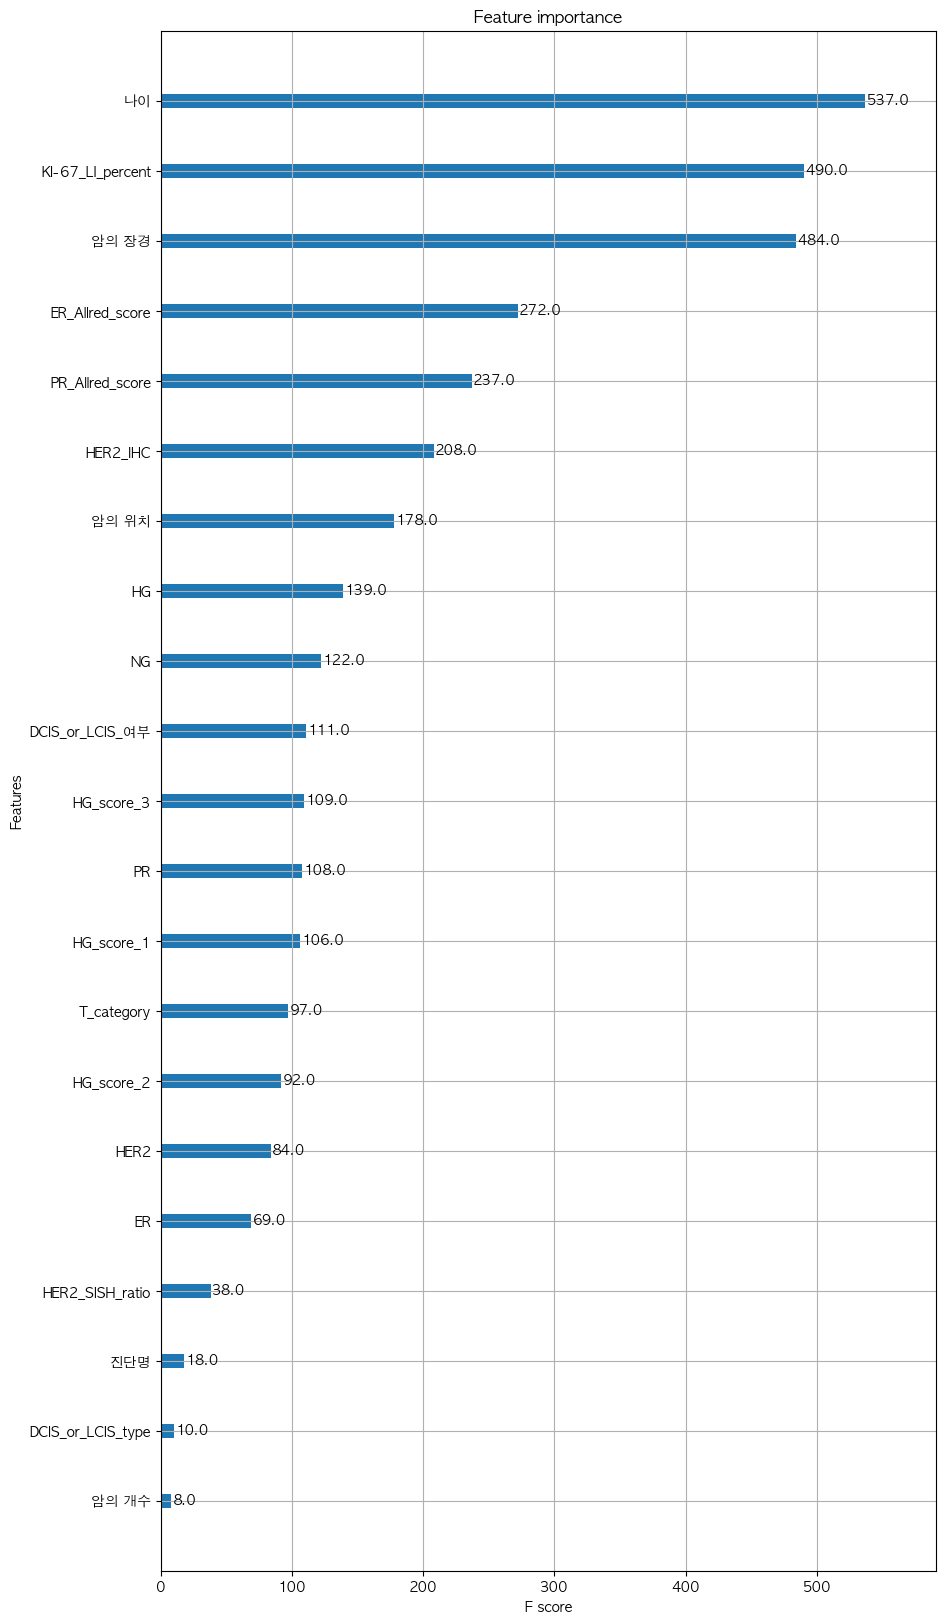

In [26]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic') 

fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(rfc, ax=ax)
plt.show()

# accuracy

In [21]:
# make predictions for test data
y_pred = rfc.predict(X_test)
predictions = [round(value) for value in y_pred]

In [22]:
# evaluate predictions
mean_squared_error(y_test, y_pred)

0.25

In [23]:
# accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 75.00%


# submission

In [24]:
y_pred = rfc.predict(test)

In [25]:
y_pred

array([1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0])